In [38]:
import pandas as pd
import numpy as np
import matplotlib as plt
import pandas_profiling
import sklearn

import seaborn as sns
%matplotlib inline

In [3]:
train_df=pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/train.csv', nrows=1000000)
test_df= pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/test.csv')

In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null object
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [24]:
profile=pandas_profiling.ProfileReport(train_df)
#If you want to generate a HTML report file, save the ProfileReport to an object and use the to_file() function:
#profile.to_file(outputfile="C:/Naveen/DC/kaggle/nytaxi/profilereport1.pdf")



In [25]:
profile.to_file(outputfile="C:/Naveen/DC/kaggle/nytaxi/profilereport2.html")

1. Fair amount price are in negative needs to be cleaned & check if too high values need to be kept or not.
2. Single passengers contribute upto 70%
3. There are 3565 records with 0 passengers & 1 record with passenger value as 208
4. dropoff lat & long has 10 NULL values each.
5. Pick up,dropoff lat & long should be within [Latitudes range from -90 to 90, Longitudes range from -180 to 180]




In [5]:
#check for missing values in train data
train_df.isnull().sum().sort_values(ascending=False)
test_df.isnull().sum().sort_values(ascending=False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
key                  0
dtype: int64

In [6]:
#drop the missing values
train_df = train_df.drop(train_df[train_df.isnull().any(1)].index, axis = 0)

In [7]:
print(train_df.shape)
print(test_df.shape)

(999990, 8)
(9914, 7)


In [8]:
train_df = train_df.drop(train_df[train_df['passenger_count']==208].index, axis = 0)

In [9]:
#Fixing latitude and longitude values [Latitudes range from -90 to 90, Longitudes range from -180 to 180]

#Latitude
train_df[train_df['pickup_latitude']<-90] # check for test data

train_df[train_df['pickup_latitude']> 90]

train_df[train_df['dropoff_latitude']<-90]

train_df[train_df['dropoff_latitude']>90]


train_df = train_df.drop(((train_df[train_df['dropoff_latitude']<-90])|(train_df[train_df['dropoff_latitude']>90])).index, axis=0)

train_df = train_df.drop(((train_df[train_df['pickup_latitude']<-90])|(train_df[train_df['pickup_latitude']>90])).index, axis=0)




In [10]:
#Longitude

train_df[train_df['pickup_longitude']< -180] #11 values

train_df[train_df['pickup_longitude'] > 180] #0 values

train_df[train_df['dropoff_longitude']< -180]

train_df[train_df['dropoff_longitude']> 180]


train_df = train_df.drop(((train_df[train_df['pickup_longitude']<-180])|(train_df[train_df['pickup_longitude']>180])).index, axis=0)

train_df = train_df.drop(((train_df[train_df['dropoff_longitude']<-180])|(train_df[train_df['dropoff_longitude']>180])).index, axis=0)

In [11]:
train_df[train_df['fare_amount'] < 0].count()
train_df = train_df.drop(train_df[train_df['fare_amount']<0].index, axis=0)

In [12]:
train_df.shape

(999911, 8)

In [13]:
train_df['key'] = pd.to_datetime(train_df['key'])
train_df['pickup_datetime']  = pd.to_datetime(train_df['pickup_datetime'])  


#Convert for test data
test_df['key'] = pd.to_datetime(test_df['key'])
test_df['pickup_datetime']  = pd.to_datetime(test_df['pickup_datetime'])

In [14]:
train_df.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [15]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train_df, test_df]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [ ]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [105]:
train_df.sample(4)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
816928,2009-02-02 14:35:00.000000800,9.3,2009-02-02 14:35:00,-73.972875,40.761497,-73.943712,40.776673,1,2.979787,2009,2,2,0,14
172028,2014-06-23 23:36:00.000000800,4.5,2014-06-23 23:36:00,-73.991085,40.735057,-73.995772,40.730907,6,0.607378,2014,6,23,0,23
653939,2009-01-15 18:09:28.000000100,7.1,2009-01-15 18:09:28,-73.965265,40.772215,-73.949923,40.784272,1,1.861778,2009,1,15,3,18
676183,2012-10-13 11:38:19.000000400,8.0,2012-10-13 11:38:19,-74.003114,40.718167,-73.994368,40.736409,1,2.158156,2012,10,13,5,11


In [17]:
train_df[train_df['fare_amount'] >150].count()


key                  108
fare_amount          108
pickup_datetime      108
pickup_longitude     108
pickup_latitude      108
dropoff_longitude    108
dropoff_latitude     108
passenger_count      108
H_Distance           108
dtype: int64

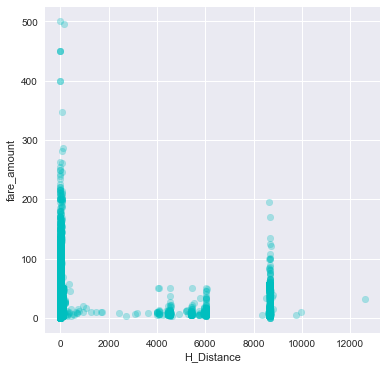

In [18]:
train_df.plot(kind='scatter',x='H_Distance',y='fare_amount',figsize=(6,6),s=45,color='c',alpha=0.3)
#plt.title('Distance & Fare Correlation')
#plt.xlabel('Distance in Kilometers (Km)')
#plt.ylabel('Fare in dollars($)')
#plt.show()

In [19]:
data = [train_df,test_df]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

In [20]:
train = train_df.drop(['key','pickup_datetime'], axis = 1)
test = test_df.drop(['key','pickup_datetime'], axis = 1)

In [21]:
X= train.iloc[:,train.columns!='fare_amount']
y = train['fare_amount'].values


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [48]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression(normalize=True)

lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [49]:
score=mean_absolute_error(y_pred,y_test)**(1/2)

print(score)

2.43950329219


In [31]:
print(train.columns)
print(test.columns)

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],
      dtype='object')
Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'H_Distance', 'Year', 'Month',
       'Date', 'Day of Week', 'Hour'],
      dtype='object')


In [41]:
lr_y_pred=lr.predict(test)

print(lr_y_pred)

[ 12.77536252  12.77186506  11.25755051 ...,  13.36681048  13.60067756
  13.18629804]


In [42]:
submission = pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/sample_submission.csv')
submission['fare_amount'] = lr_y_pred
submission.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_LR.csv', index=False)
submission.head(20) #9.32625

#test['fare_amount'] = lr_y_pred
#test.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_LR.csv', index=False)
#test.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,12.775363
1,2015-01-27 13:08:24.0000003,12.771865
2,2011-10-08 11:53:44.0000002,11.257551
3,2012-12-01 21:12:12.0000002,11.807293
4,2012-12-01 21:12:12.0000003,11.812135
5,2012-12-01 21:12:12.0000005,11.809158
6,2011-10-06 12:10:20.0000001,11.227208
7,2011-10-06 12:10:20.0000003,11.235807
8,2011-10-06 12:10:20.0000002,11.223870
9,2014-02-18 15:22:20.0000002,12.168895


In [45]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor()

DT.fit(X_train,y_train)
y_pred_dt=DT.predict(X_test)

In [54]:
dt_score=mean_absolute_error(y_pred_dt,y_test)**(1/2)

print(dt_score)

1.62150773267


In [38]:
dt_y_pred=DT.predict(test)

In [ ]:
submission = pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/sample_submission.csv')
submission['fare_amount'] = dt_y_pred
submission.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_DT.csv', index=False)
submission.head(20)  # 4.79943

#test['fare_amount'] = lr_y_pred
#test.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_LR.csv', index=False)
#test.head(20)

In [51]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()

RF.fit(X_train,y_train)
y_pred_rf=RF.predict(X_test)

In [59]:
rf_score=mean_absolute_error(y_pred_rf,y_test)**(1/2)

print(rf_score)

1.41194693854


In [57]:
rf_y_pred=DT.predict(test)

In [58]:
submission = pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/sample_submission.csv')
submission['fare_amount'] = rf_y_pred
submission.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_RF.csv', index=False)
submission.head(20) #4.90269

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.5
1,2015-01-27 13:08:24.0000003,9.0
2,2011-10-08 11:53:44.0000002,3.7
3,2012-12-01 21:12:12.0000002,7.5
4,2012-12-01 21:12:12.0000003,15.0
5,2012-12-01 21:12:12.0000005,9.0
6,2011-10-06 12:10:20.0000001,5.3
7,2011-10-06 12:10:20.0000003,49.8
8,2011-10-06 12:10:20.0000002,8.5
9,2014-02-18 15:22:20.0000002,6.0


In [122]:
from sklearn.model_selection import GridSearchCV

params_rf = {'n_estimators':[10,35,50],'max_features':['log2','auto','sqrt'],
    'min_samples_leaf':[5,15,25]
}

rf = RandomForestRegressor()

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='mean_squared_error',
                       cv=4,
                       verbose=1,
                       n_jobs=-1)



In [123]:
grid_rf.fit(X_train, y_train)


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 109.6min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 35, 50], 'max_features': ['log2', 'auto', 'sqrt'], 'min_samples_leaf': [5, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='mean_squared_error', verbose=1)

In [124]:
print(best_model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [125]:

from sklearn.metrics import mean_squared_error as MSE

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred_gridrf = best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_pred_gridrf,y_pred)**(1/2)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 8.879


In [127]:
gridrf_y_pred=best_model.predict(test)

In [128]:
submission = pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/sample_submission.csv')
submission['fare_amount'] = gridrf_y_pred
submission.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_GridRF4.csv', index=False)
submission.head(20) #3.22986  #cv=3, 

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.393984
1,2015-01-27 13:08:24.0000003,9.938683
2,2011-10-08 11:53:44.0000002,4.569780
3,2012-12-01 21:12:12.0000002,8.915863
4,2012-12-01 21:12:12.0000003,16.520551
5,2012-12-01 21:12:12.0000005,10.457346
6,2011-10-06 12:10:20.0000001,5.084233
7,2011-10-06 12:10:20.0000003,49.091460
8,2011-10-06 12:10:20.0000002,10.654810
9,2014-02-18 15:22:20.0000002,6.089084


In [90]:
       estimator= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [91]:
estimator.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [92]:


# Predict test set labels
y_pred_gridrf2 = estimator.predict(X_test)

# Compute rmse_test
rmse_test2 = MSE(y_pred_gridrf2,y_pred)**(1/2)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test2)) 

Test RMSE of best model: 8.980


In [93]:
gridrf_y_pred2=estimator.predict(test)

In [94]:
submission = pd.read_csv('C:/Naveen/DC/kaggle/nytaxi/sample_submission.csv')
submission['fare_amount'] = gridrf_y_pred2
submission.to_csv('C:/Naveen/DC/kaggle/nytaxi/submission_GridRF2.csv', index=False)
submission.head(20) # 3.3xxx did not improve much

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.0050
1,2015-01-27 13:08:24.0000003,10.8850
2,2011-10-08 11:53:44.0000002,4.8320
3,2012-12-01 21:12:12.0000002,9.3890
4,2012-12-01 21:12:12.0000003,16.7900
5,2012-12-01 21:12:12.0000005,11.5190
6,2011-10-06 12:10:20.0000001,5.2800
7,2011-10-06 12:10:20.0000003,48.2389
8,2011-10-06 12:10:20.0000002,14.3690
9,2014-02-18 15:22:20.0000002,6.2800


In [42]:
#PLOTLY
import plotly
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#import cufflinks as cf
from plotly.graph_objs import Scatter, Figure, Layout
#cf.set_config_file(offline=True)

In [50]:
data = [go.Scattermapbox(
            lat= train['pickup_latitude'][:10000] ,
            lon= train['pickup_longitude'][:10000],
           # customdata = train['key'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'gold',
                opacity = .8,
                name ='pickuplocations'
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken="pk.eyJ1IjoibmF2ZWVuc2FsaXlhbiIsImEiOiJjamx4aDZ6aDQwOW50M3ZvaDZtdmFheW8xIn0.bUgKLA4KnTWkbTgSpPIjaw",
                                bearing=10,
                                pitch=60,
                                zoom=13,
                                center= dict(
                                         lat=40.721319,
                                         lon=-73.987130),
                                style= "mapbox://styles/naveensaliyan/cjlxig8v24n4h2smv1i2wfmxj"),
                    width=900,
                    height=600, title = "Pick up Locations in NewYork")

ValueError: Invalid property specified for object of type plotly.graph_objs.scattermapbox.Marker: 'name'

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `marker.colorscale`. Has an effect only if in
            `marker.color`is set to a numerical array. In case
            `colorscale` is unspecified or `autocolorscale` is
            true, the default  palette will be chosen according to
            whether numbers in the `color` array are all positive,
            all negative or mixed.
        cauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `marker.color`)
            or the bounds set in `marker.cmin` and `marker.cmax`
            Has an effect only if in `marker.color`is set to a
            numerical array. Defaults to `false` when `marker.cmin`
            and `marker.cmax` are set by the user.
        cmax
            Sets the upper bound of the color domain. Has an effect
            only if in `marker.color`is set to a numerical array.
            Value should have the same units as in `marker.color`
            and if set, `marker.cmin` must be set as well.
        cmin
            Sets the lower bound of the color domain. Has an effect
            only if in `marker.color`is set to a numerical array.
            Value should have the same units as in `marker.color`
            and if set, `marker.cmax` must be set as well.
        color
            Sets themarkercolor. It accepts either a specific color
            or an array of numbers that are mapped to the
            colorscale relative to the max and min values of the
            array or relative to `marker.cmin` and `marker.cmax` if
            set.
        colorbar
            plotly.graph_objs.scattermapbox.marker.ColorBar
            instance or dict with compatible properties
        colorscale
            Sets the colorscale. Has an effect only if in
            `marker.color`is set to a numerical array. The
            colorscale must be an array containing arrays mapping a
            normalized value to an rgb, rgba, hex, hsl, hsv, or
            named color string. At minimum, a mapping for the
            lowest (0) and highest (1) values are required. For
            example, `[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]`.
            To control the bounds of the colorscale in color space,
            use`marker.cmin` and `marker.cmax`. Alternatively,
            `colorscale` may be a palette name string of the
            following list: Greys,YlGnBu,Greens,YlOrRd,Bluered,RdBu
            ,Reds,Blues,Picnic,Rainbow,Portland,Jet,Hot,Blackbody,E
            arth,Electric,Viridis,Cividis.
        colorsrc
            Sets the source reference on plot.ly for  color .
        opacity
            Sets the marker opacity.
        opacitysrc
            Sets the source reference on plot.ly for  opacity .
        reversescale
            Reverses the color mapping if true. Has an effect only
            if in `marker.color`is set to a numerical array. If
            true, `marker.cmin` will correspond to the last color
            in the array and `marker.cmax` will correspond to the
            first color.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace. Has an effect only if in `marker.color`is
            set to a numerical array.
        size
            Sets the marker size (in px).
        sizemin
            Has an effect only if `marker.size` is set to a
            numerical array. Sets the minimum size (in px) of the
            rendered marker points.
        sizemode
            Has an effect only if `marker.size` is set to a
            numerical array. Sets the rule for which the data in
            `size` is converted to pixels.
        sizeref
            Has an effect only if `marker.size` is set to a
            numerical array. Sets the scale factor used to
            determine the rendered size of marker points. Use with
            `sizemin` and `sizemode`.
        sizesrc
            Sets the source reference on plot.ly for  size .
        symbol
            Sets the marker symbol. Full list:
            https://www.mapbox.com/maki-icons/ Note that the array
            `marker.color` and `marker.size` are only available for
            *circle* symbols.
        symbolsrc
            Sets the source reference on plot.ly for  symbol .
        

In [51]:
fig = dict(data=data, layout=layout)
iplot(fig)

In [45]:
data = [go.Scattermapbox(
            lat= train['dropoff_latitude'][:1000] ,
            lon= train['dropoff_longitude'][:1000],
           # customdata = train['key'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'cyan',
                opacity = .8,
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken="pk.eyJ1Ijoic2hhejEzIiwiYSI6ImNqYXA3NjhmeDR4d3Iyd2w5M2phM3E2djQifQ.yyxsAzT94VGYYEEOhxy87w",
                                bearing=10,
                                pitch=60,
                                zoom=13,
                                center= dict(
                                         lat=40.721319,
                                         lon=-73.987130),
                                style= "mapbox://styles/shaz13/cjk4wlc1s02bm2smsqd7qtjhs"),
                    width=900,
                    height=600, title = "Drop off locations in Newyork")
fig = dict(data=data, layout=layout)
iplot(fig)